In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

%matplotlib inline

In [2]:
data = pd.read_csv("performance_year_financial_and_quality_results_puf_2020_01_01.csv")

# EDA

Text(0.5, 1.0, 'Expenditures for different categories of hospital care')

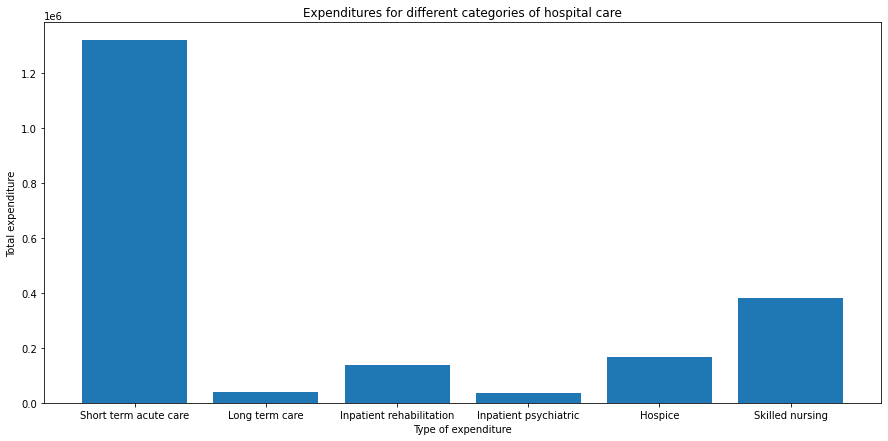

In [84]:
# Expenditures from several different sources
figure, ax = plt.subplots(1,1, figsize=(15,7))

x_group = data[['CapAnn_INP_S_trm', 'CapAnn_INP_L_trm', 'CapAnn_INP_Rehab', 'CapAnn_INP_Psych', 'CapAnn_HSP', 'CapAnn_SNF']].sum()
plt.bar(['Short term acute care', 'Long term care', 'Inpatient rehabilitation', 'Inpatient psychiatric',  'Hospice','Skilled nursing'], x_group)
plt.ylabel('Total expenditure')
plt.xlabel('Type of expenditure')
plt.title('Expenditures for different categories of hospital care')

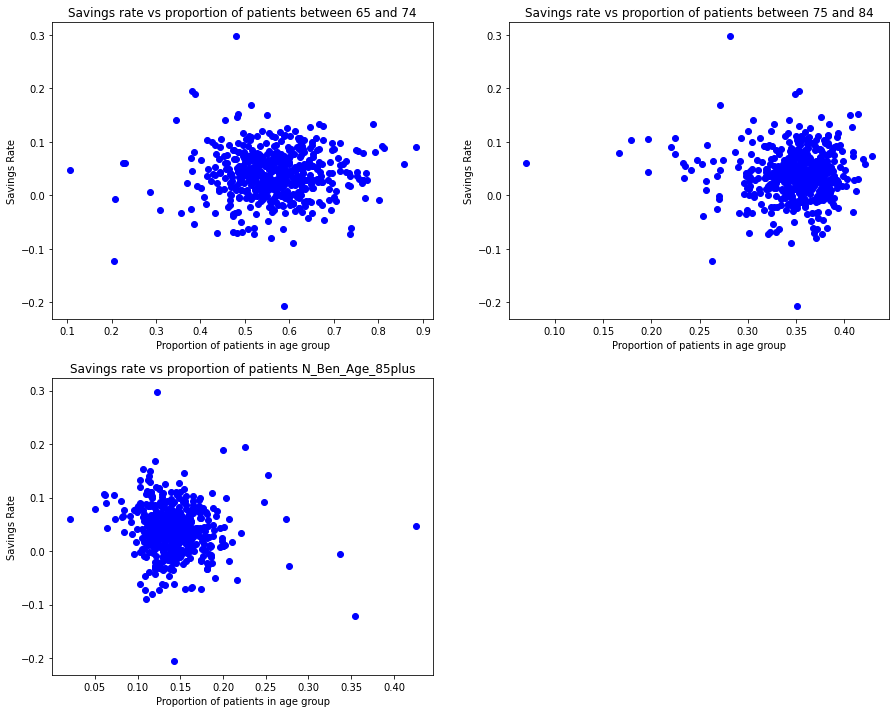

In [74]:
# Do ACOs with a higher proportion of older patients perform worse than ACOs that serve younger patients

figure, axs = plt.subplots(2,2, figsize=(15,12))
axs = axs.ravel()
axs[3].axis('off')

total_patients = data['N_Ben_Age_0_64'] + data['N_Ben_Age_75_84'] + data['N_Ben_Age_75_84'] + data['N_Ben_Age_85plus']
x_list = ['N_Ben_Age_65_74', 'N_Ben_Age_75_84', 'N_Ben_Age_85plus']
labels = ['between 65 and 74', 'between 75 and 84', 'N_Ben_Age_85plus']
for i in range(3):
    axs[i].scatter(data[x_list[i]]/total_patients , data['Sav_rate'], color='b')
    axs[i].set(title="Savings rate vs proportion of patients " + labels[i], xlabel="Proportion of patients in age group", ylabel="Savings Rate");

Text(0.5, 1.0, 'Savings Rate vs per capital ambulance expenditures')

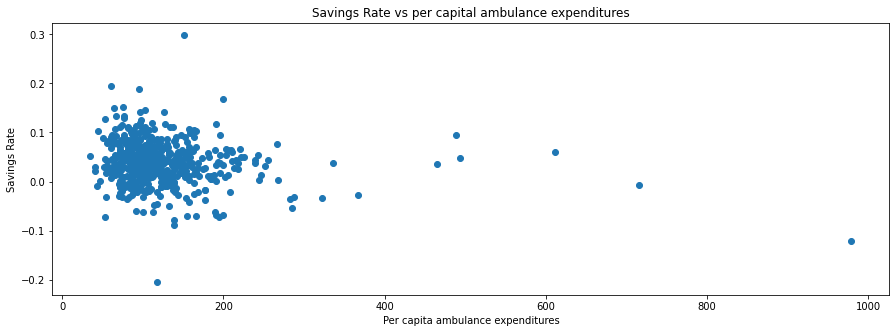

In [65]:
# Does a greater amount of ambulance expenditures reduce savings rate
figure, ax = plt.subplots(1,1, figsize=(15,5))
plt.scatter(data["CapAnn_AmbPay"], data['Sav_rate'])
plt.xlabel("Per capita ambulance expenditures")
plt.ylabel("Savings Rate")
plt.title("Savings Rate vs per capital ambulance expenditures")

# Baseline modelling

## Linear Model

In [7]:
#Baseline Model

#all of these are directly tied to the response variable and as such we do not want them as predictors
vars_to_exclude = ["EarnSaveLoss", "GenSaveLoss","BnchmkMinExp"] 
data_mod = data.drop(vars_to_exclude, axis=1)

#Drop non-relevant categorial columns
cat_cols_to_encode = ["Rev_Exp_Cat", "Risk_Model", "Agree_Type"]
cols = data_mod.columns
num_cols = data_mod._get_numeric_data().columns
vars_to_exclude = list(set(cols) - set(num_cols) - set(cat_cols_to_encode))
data_mod = data_mod.drop(vars_to_exclude, axis=1)

#one-hot encode relevant categorial columns
data_mod = pd.get_dummies(data_mod, columns=cat_cols_to_encode)

nans = ['DisAdj', 'PosRegAdj', 'Adv_Pay_Amt','Adv_Pay_Recoup']
data_mod = data_mod.drop(nans, axis=1)

X = data_mod.drop(['Sav_rate'], axis=1)
y = data_mod['Sav_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=34)

linr = LinearRegression()

linr.fit(X_train, y_train)

print(f"Linear Regression Training Score: {linr.score(X_train, y_train):.3f}")
print(f"Linear Regression Test Score: {linr.score(X_test, y_test):.3f}")

cols = X.columns
coef_scale = abs(linr.coef_)

features, importance = (list(t) for t in zip(*sorted(zip(cols, coef_scale))))
print("10 Most Important Features: ",features[:10])

Linear Regression Training Score: 0.981
Linear Regression Test Score: 0.894
10 Most Important Features:  ['ABtotBnchmk', 'ABtotExp', 'ACO43', 'ADM', 'ADM_L_Trm', 'ADM_Psych', 'ADM_Rehab', 'ADM_S_Trm', 'AIM', 'Adv_Pay']


## Random Forest

In [12]:
#Random Forest Model
X = data_mod.drop(['Sav_rate'], axis=1)
y = data_mod['Sav_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=34)

rf = RandomForestRegressor(max_features='sqrt')
rf.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt')

In [13]:
print(f"Random Forest Training Score: {rf.score(X_train, y_train):.3f}")
print(f"Random Forest Test Score: {rf.score(X_test, y_test):.3f}")

cols = X.columns
feat_importances = rf.feature_importances_

features, importance = (list(t) for t in zip(*sorted(zip(cols, feat_importances))))
print("10 Most Important Features: ",features[:10])

Random Forest Training Score: 0.909
Random Forest Test Score: 0.416
10 Most Important Features:  ['ABtotBnchmk', 'ABtotExp', 'ACO43', 'ADM', 'ADM_L_Trm', 'ADM_Psych', 'ADM_Rehab', 'ADM_S_Trm', 'AIM', 'Adv_Pay']
